In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_figlet.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_figlettest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.324094,0.006131,911.319040,49312.485831,0.010610,1355.186590,7327.460939,1.0,103.0,0.101562,6.0,65.278711,2.508814e+10,19.192693
1,0.435870,0.012711,12652.088889,99214.222222,0.010610,5997.000000,17316.288889,1.0,251.0,0.103955,6.0,65.278711,2.508814e+10,19.192693
2,0.468027,0.012978,12652.088889,101398.755556,0.033712,8108.177778,21682.377778,1.0,396.0,0.106485,6.0,11.526728,2.508814e+10,19.333974
3,0.465293,0.014400,11832.888889,128341.333333,0.033712,9869.933333,22551.844444,1.0,542.0,0.105202,6.0,11.526728,2.508814e+10,19.333974
4,0.461566,0.010489,0.000000,90294.044444,0.037694,7584.933333,18696.533333,1.0,585.0,0.102712,6.0,11.493428,2.508814e+10,19.054890


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,2.624204,481.508966,0.101562,103.0
1,2.624204,481.508966,0.103955,251.0
2,0.463374,485.053440,0.106485,396.0
3,0.463374,485.053440,0.105202,542.0
4,0.462036,478.051738,0.102712,585.0


In [6]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
#x_train = preprocessing.normalize(x_train, norm='max')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
#x_test = preprocessing.normalize(x_test, norm='max')

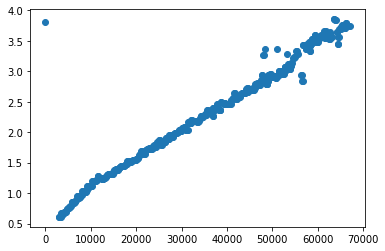

In [7]:
plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )

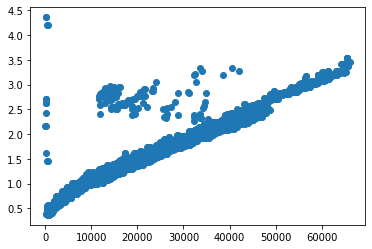

In [8]:
plt.scatter(df_t['requests'], df_t['total_cpu_util'] )

## Linear Regression

Training Score  0.8425695590433684
Testing Score  0.9758850034493384


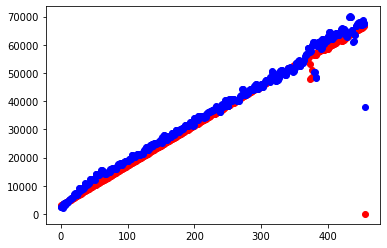

In [9]:
parameters = {'fit_intercept': [True,False],
             'copy_X': [True,False]}
#linear = GridSearchCV(LinearRegression(),
#                      parameters, 
#                      cv=7,
#                      scoring='r2',
#                      n_jobs=-1)
linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
y_te_pred = linear.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
print("Testing Score ",linear.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

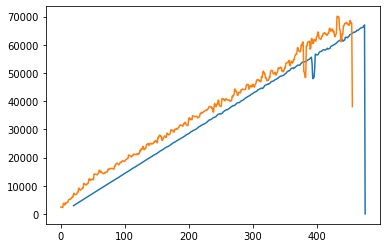

In [10]:
plt.plot(y_test)
plt.plot(y_te_pred)

## Polynomial Regression

Training Score  0.927439816932051
Testing Score  0.09418275739454363
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


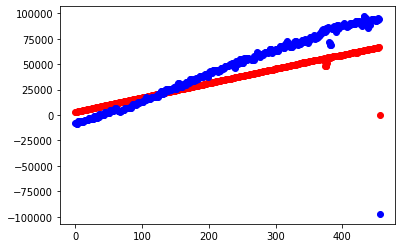

In [11]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2,3,4,5,6 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
y_te_pred = polynomial.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
print("Testing Score ",polynomial.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Ridge Regression

Training Score  0.8425695590433684
Testing Score  0.9758850034493383
Best Params:  {'alpha': 1e-20, 'fit_intercept': False, 'max_iter': 10, 'solver': 'svd'}


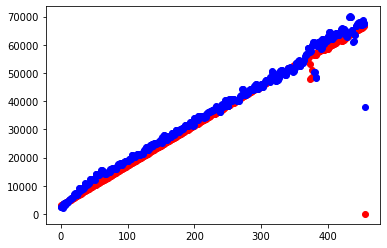

In [12]:
alphas = np.logspace(-20,10,num=20)
param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
            'solver': ['auto', 'svd'],
             'fit_intercept':[True, False]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
y_te_pred = ridge_cv.predict(x_test)

print("Training Score ",ridge_cv.score(x_train,y_train))
print("Testing Score ",ridge_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Lasso Regression

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:   15.1s


Training Score  0.8211938588307026
Testing Score  0.9535342285983701
Best Params:  {'alpha': 1.4384498882876658e-17, 'copy_X': False, 'fit_intercept': False, 'max_iter': 30, 'positive': False, 'selection': 'random', 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 17273 out of 17280 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:   23.7s finished
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59828323851.2052, tolerance: 257246395.4038
  positive)


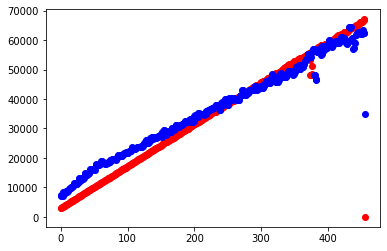

In [13]:
alphas = np.logspace(-20,10,num=20)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
             'fit_intercept':[True, False],
             'selection': ['cyclic', 'random'],
             'positive':[True, False],
             'warm_start':[True, False],
             'copy_X':[True, False]}

lasso_cv = GridSearchCV(Lasso(),
                       param_grid=param_grid,
                         cv=3, 
                        scoring='r2',
                         n_jobs=-1,
                       verbose=1)

lasso_cv.fit(x_train, y_train)

y_tr_pred = lasso_cv.predict(x_train)
y_te_pred = lasso_cv.predict(x_test)

print("Training Score ",lasso_cv.score(x_train,y_train))
print("Testing Score ",lasso_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', lasso_cv.best_score_)
print('Best Params: ', lasso_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Huber Regressor

Fitting 3 folds for each of 7200 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 6680 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 12280 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 19480 tasks      | elapsed:  1.4min


Training Score  0.7525670619504656
Testing Score  0.9375374063516414
Best Params:  {'alpha': 1.4384498882876658e-17, 'epsilon': 1.3500000000000003, 'fit_intercept': True, 'max_iter': 30, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 21600 out of 21600 | elapsed:  1.5min finished
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:86: RuntimeWarning: invalid value encountered in double_scalars
  squared_loss = weighted_loss / sigma
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:96: RuntimeWarning: invalid value encountered in multiply
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:117: RuntimeWarning: invalid value encountered in double_scalars
  grad[-2] = -2. * np.sum(weighted_non_outliers) / sigma
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to

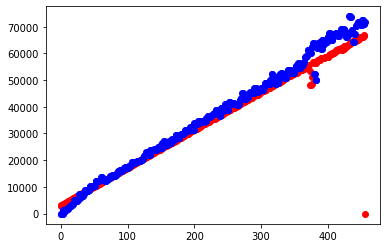

In [14]:
epsilon = np.arange(1, 1.5, 0.05)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
              'epsilon': epsilon,
             'fit_intercept':[True, False],
             'warm_start':[True, False]}

huber_cv = GridSearchCV(HuberRegressor(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1,
                       verbose=1)

huber_cv.fit(x_train, y_train)

y_tr_pred = huber_cv.predict(x_train)
y_te_pred = huber_cv.predict(x_test)

print("Training Score ",huber_cv.score(x_train,y_train))
print("Testing Score ",huber_cv.score(x_test,y_test))



#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', huber_cv.best_score_)
print('Best Params: ', huber_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Random Forrest Regressor

Training Score  0.9686952890445005
Testing Score  0.8911572898443354
Best Params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100}


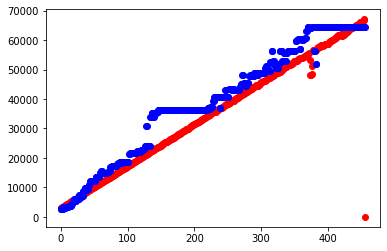

In [15]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': np.arange(1,6,1),
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=3, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
y_te_pred = rf_cv.predict(x_test)


print("Training Score ",rf_cv.score(x_train,y_train))
print("Testing Score ",rf_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

Test R² : 0.8952744645579611
Train R² : 0.9878320558480846


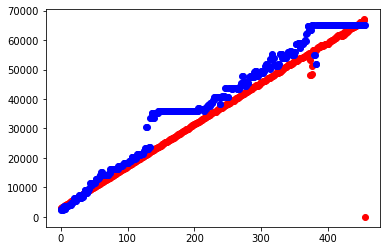

In [16]:
finalrf_cv = RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=150)
finalrf_cv.fit(x_train, y_train)
y_tr_pred = finalrf_cv.predict(x_train)
y_te_pred = finalrf_cv.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## ElasticNet

Training Score  0.8548245373350756
Testing Score  0.7847302062642654
Best Params:  {'alpha': 1.4384498882876658e-17, 'l1_ratio': 0.5}


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48575388266.94417, tolerance: 66919764.00805887
  positive)


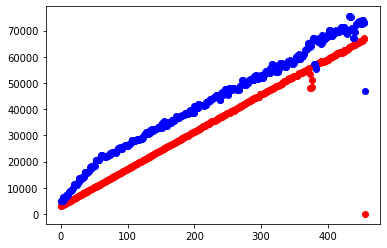

In [17]:
# find optimal alpha with grid search
alpha = np.logspace(-20,10,num=20)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(ElasticNet(), 
                    param_grid=param_grid,
                    cv=7,
                    scoring='r2', 
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

y_tr_pred = grid.predict(x_train)
y_te_pred = grid.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Gradient Boosting Regressor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 23.4min finished


Training Score  0.8548245373350756
Testing Score  0.7847302062642654
Best Params:  {'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 1000}


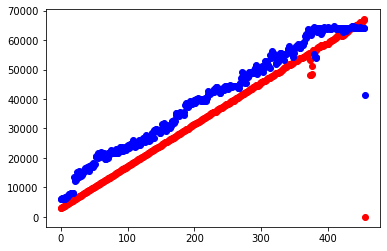

In [18]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                 'learning_rate': [0.02],
                 'min_samples_split': [10, 15, 20],
                 'min_samples_leaf': [10, 15, 20],
                 'max_depth': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000],
                 'loss': ['ls', 'lad', 'huber', 'quantile'],
                 'max_features': ['sqrt']
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
y_te_pred = GBoost_cv.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')